## Steel price regression - 환율 선 적용

## 변수 정의
### 1. 국내
* weightA: 철 스크랩, 중량A 평균가

### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)

### 3. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)

### 4. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


### Scrap가 부서공식 
* 스크랩가 = weightA*0.7 + importPriceJP*0.2 + importPriceUSA*0.1

In [63]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf

In [64]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
import matplotlib
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'AppleGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
pd.set_option('display.max_rows', 500)

In [67]:
df_raw = pd.read_csv("./data/rated_previous_prices.csv")
#날짜형으로 변환
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y-%m-%d')
df_raw = df_raw.sort_values(by=['date'], ascending=True, ignore_index=True)
df_raw.head()

,date,gosi,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR
0,2017-01-06,620,295,301955.5,260931.7,302432.9,337760.5,334180.0,869,1193.5,1027.29
1,2017-01-13,620,280,294925.0,263114.0,297745.0,327825.0,329000.0,846,1175.0,1023.79
2,2017-01-20,620,270,294674.0,261391.4,297491.6,327546.0,316980.0,944,1174.0,1021.06
3,2017-01-27,620,270,296437.5,260719.7,294577.5,324337.5,290625.0,1019,1162.5,1022.43
4,2017-02-03,620,264,280356.0,256797.5,291501.3,320571.0,281505.0,1007,1149.0,1015.01


In [68]:
# 결측치 확인
df_raw.isnull().sum()

#df는 계산을 위한 dataframe
df = df_raw.copy()
df['scrap'] = df['weightA']*0.7 + df['importPriceJP']*0.2 + df['importPriceUSA']*0.1
#단위 통화 통일 (톤/원) (재고량:천톤 제외)
df['weightA']= df['weightA'] * 1000
df['gosi'] = df['gosi'] * 1000

#순서변경
col2 = df.columns[3:].to_list()
col_date = df.columns[:1].to_list()
col_gosi = df.columns[1:2].to_list()
col_weight = df.columns[2:3].to_list()
df = df[col_date + col_weight+ col_gosi + col2]
df.head()


,date,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap
0,2017-01-06,295000,620000,301955.5,260931.7,302432.9,337760.5,334180.0,869,1193.5,1027.29,100818.55
1,2017-01-13,280000,620000,294925.0,263114.0,297745.0,327825.0,329000.0,846,1175.0,1023.79,98778.50
2,2017-01-20,270000,620000,294674.0,261391.4,297491.6,327546.0,316980.0,944,1174.0,1021.06,96339.60
3,2017-01-27,270000,620000,296437.5,260719.7,294577.5,324337.5,290625.0,1019,1162.5,1022.43,90747.75
4,2017-02-03,264000,620000,280356.0,256797.5,291501.3,320571.0,281505.0,1007,1149.0,1015.01,88542.90


In [69]:
df_raw.describe()

,gosi,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,712.591093,330.275304,351756.425101,309590.744534,437604.923482,384004.273684,362342.087045,932.481781,1143.155870,1045.737571
std,68.578236,75.195714,74826.533268,74634.287365,106038.575876,79793.443792,80223.509295,114.046091,41.714952,48.943766
min,620.000000,227.000000,239976.000000,200599.200000,248183.000000,282430.000000,224220.000000,596.000000,1062.500000,939.650000
25%,660.000000,275.000000,297468.750000,254212.300000,382099.500000,330020.000000,306472.500000,854.500000,1118.500000,1008.745000
50%,714.000000,319.000000,332220.000000,297836.500000,442152.000000,365134.000000,352485.000000,936.000000,1134.500000,1032.070000
75%,731.000000,349.500000,372495.000000,340435.250000,463406.000000,396765.000000,391300.000000,1015.500000,1175.250000,1083.485000
max,930.000000,551.000000,559559.000000,520625.100000,734653.500000,613107.500000,632905.000000,1205.000000,1241.500000,1153.840000


In [70]:
df.head()

,date,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap
0,2017-01-06,295000,620000,301955.5,260931.7,302432.9,337760.5,334180.0,869,1193.5,1027.29,100818.55
1,2017-01-13,280000,620000,294925.0,263114.0,297745.0,327825.0,329000.0,846,1175.0,1023.79,98778.50
2,2017-01-20,270000,620000,294674.0,261391.4,297491.6,327546.0,316980.0,944,1174.0,1021.06,96339.60
3,2017-01-27,270000,620000,296437.5,260719.7,294577.5,324337.5,290625.0,1019,1162.5,1022.43,90747.75
4,2017-02-03,264000,620000,280356.0,256797.5,291501.3,320571.0,281505.0,1007,1149.0,1015.01,88542.90


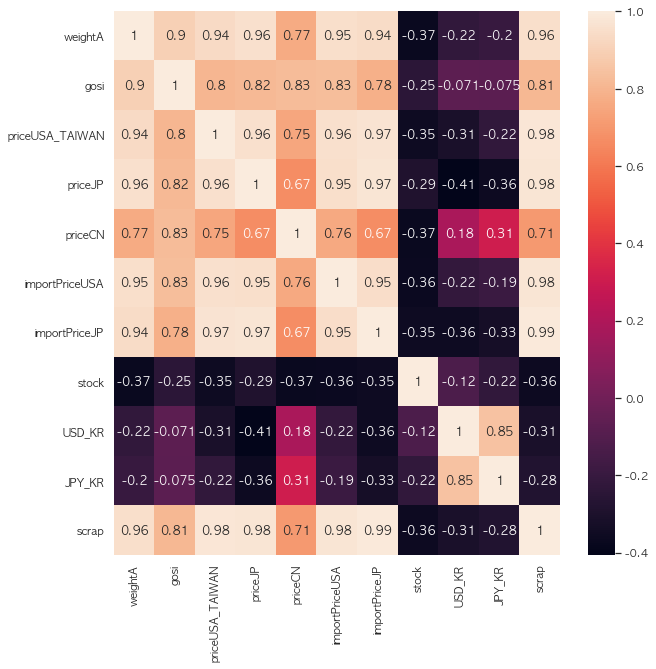

In [71]:
# 상관관계 분석  
import seaborn as sns
# 상관관계 행렬 
df_corr = df.corr()
#Drawing HEAT MAP
fig = plt.figure (figsize=(10,10))
sns.set(font_scale=1, font="AppleGothic")
sns.heatmap(df_corr, annot=True, cbar=True);
plt.show()


fig.savefig('./result_img01/corr_heatmap.png', dpi = 100)

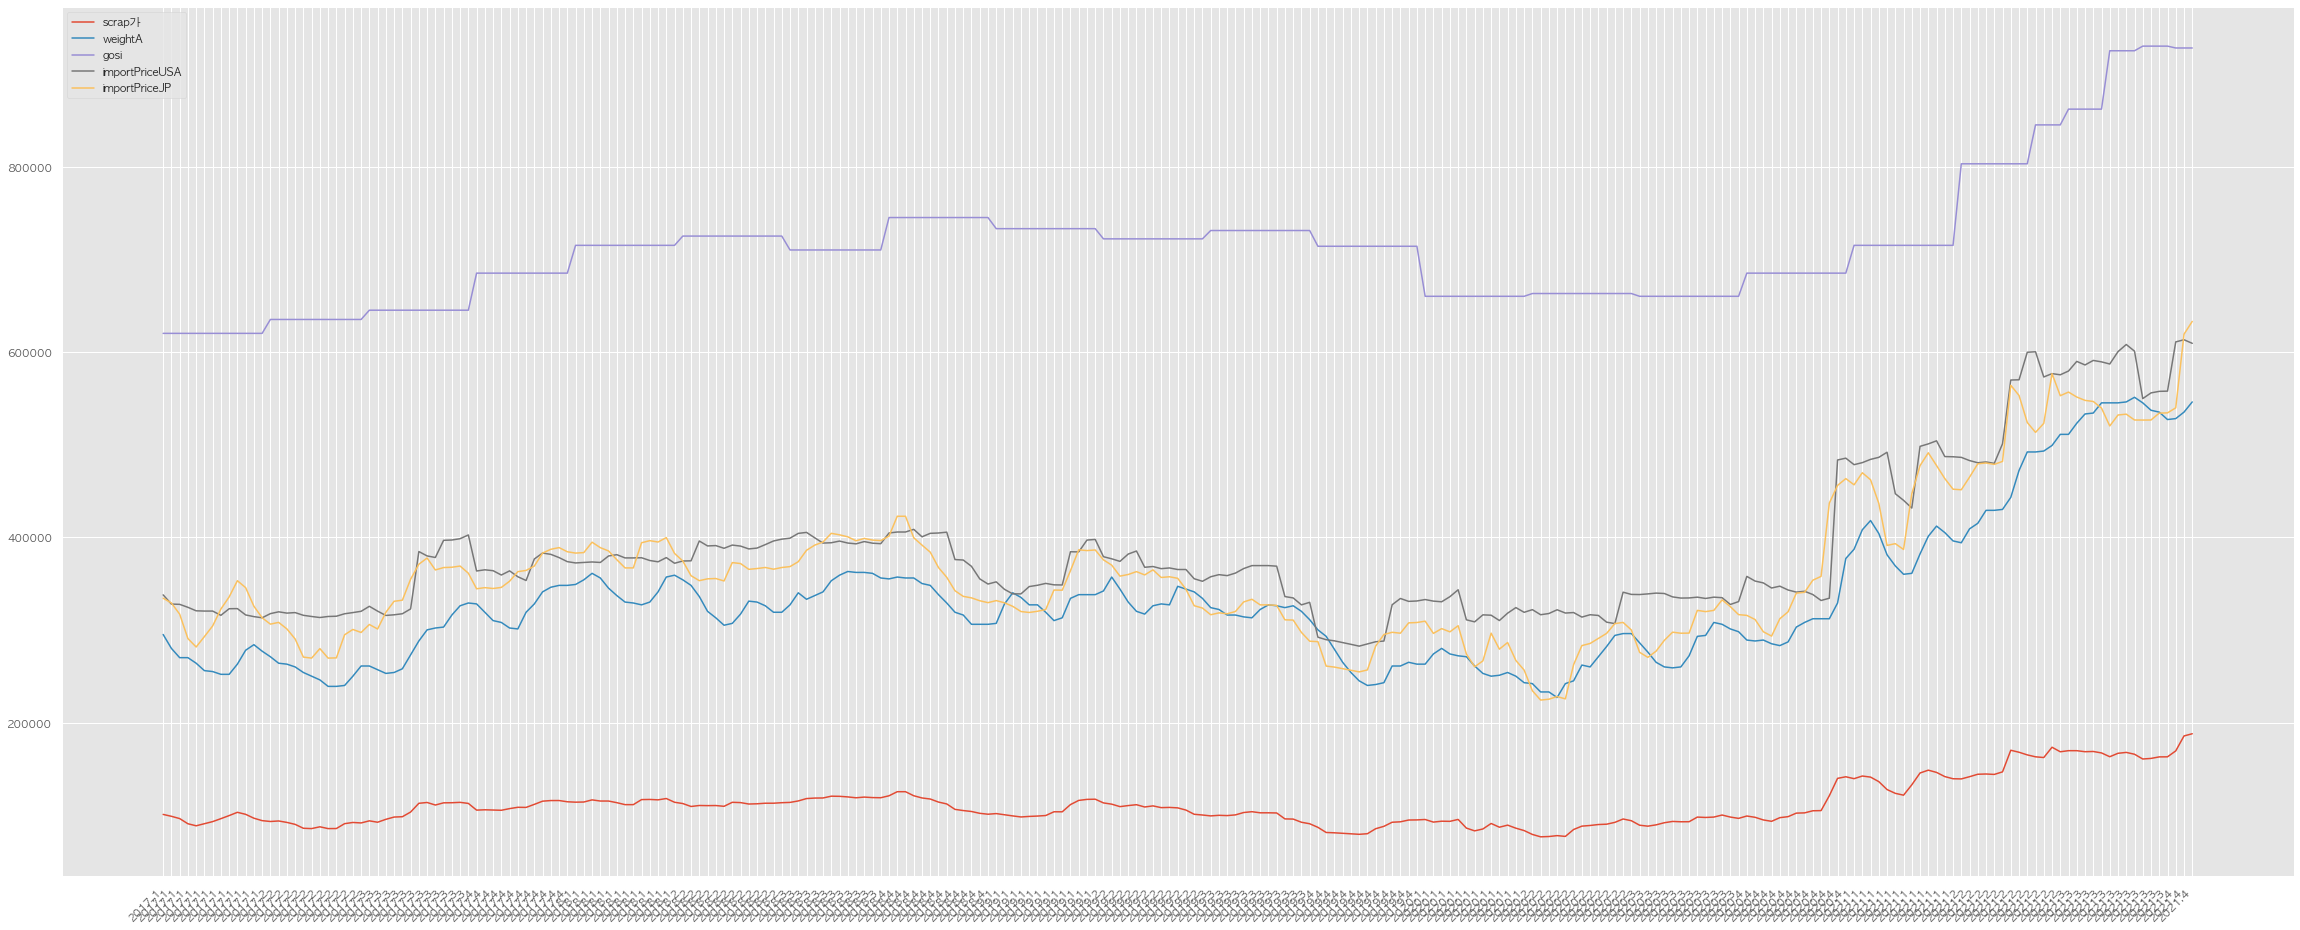

In [72]:
dfg = df
# 그래프를 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
dfg['quarter'] = df['date'].dt.year+ (df.date.dt.quarter)*0.1
#비고, stock은 시계열 데이터 특징을 가짐
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,16)
xi = list(range(len(dfg)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, dfg['scrap'], label = 'scrap가')
ay.plot(df.index, dfg['weightA'], label = 'weightA')
ay.plot(df.index, dfg['gosi'], label = 'gosi')
ay.plot(df.index, dfg['importPriceUSA'], label = 'importPriceUSA')
ay.plot(df.index, dfg['importPriceJP'], label = 'importPriceJP')

plt.xticks(xi, dfg['quarter'])
ay.set_xticklabels(dfg['quarter'], rotation = 45, ha="right")
plt.legend() 

plt.show()

fig.savefig('./result_img01/scrap_with3prices.png', dpi = 100)


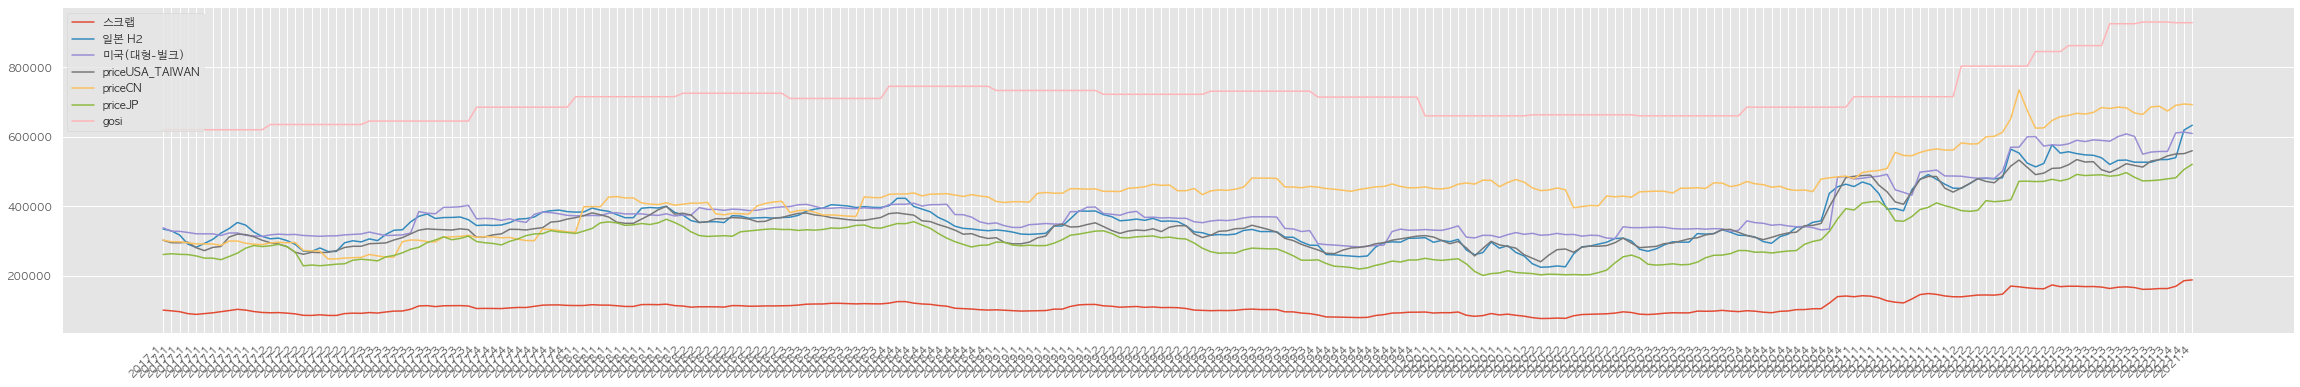

In [73]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(dfg)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, dfg['scrap'] , label = '스크랩')
ay.plot(df.index, dfg['importPriceJP'], label='일본 H2')
ay.plot(df.index, dfg['importPriceUSA'], label = "미국(대형-벌크)")
ay.plot(df.index, dfg['priceUSA_TAIWAN'], label = "priceUSA_TAIWAN")
ay.plot(df.index, dfg['priceCN'], label = "priceCN")
ay.plot(df.index, dfg['priceJP'], label = "priceJP")
ay.plot(df.index, dfg['gosi'] , label = 'gosi')

plt.xticks(xi, dfg['quarter'])

ay.set_xticklabels(dfg['quarter'], rotation = 45, ha="right")
plt.legend()
plt.show()

fig.savefig('./result_img01/fig4.png', dpi = 100)

In [74]:
# 비고, stock은 시계열 데이터 특징을 가짐 
# 도메인 전문가 의견(부서) -> Stock의 중간값이 상향/하향일 때 분기고시가와 weightA가 영향을 받을 수 있다고 함.
# 시계열 모델 fb prophet으로 추출한 중간값인 추세선을 설명변수로 추가

In [75]:
from prophet import Prophet
import pandas as pd

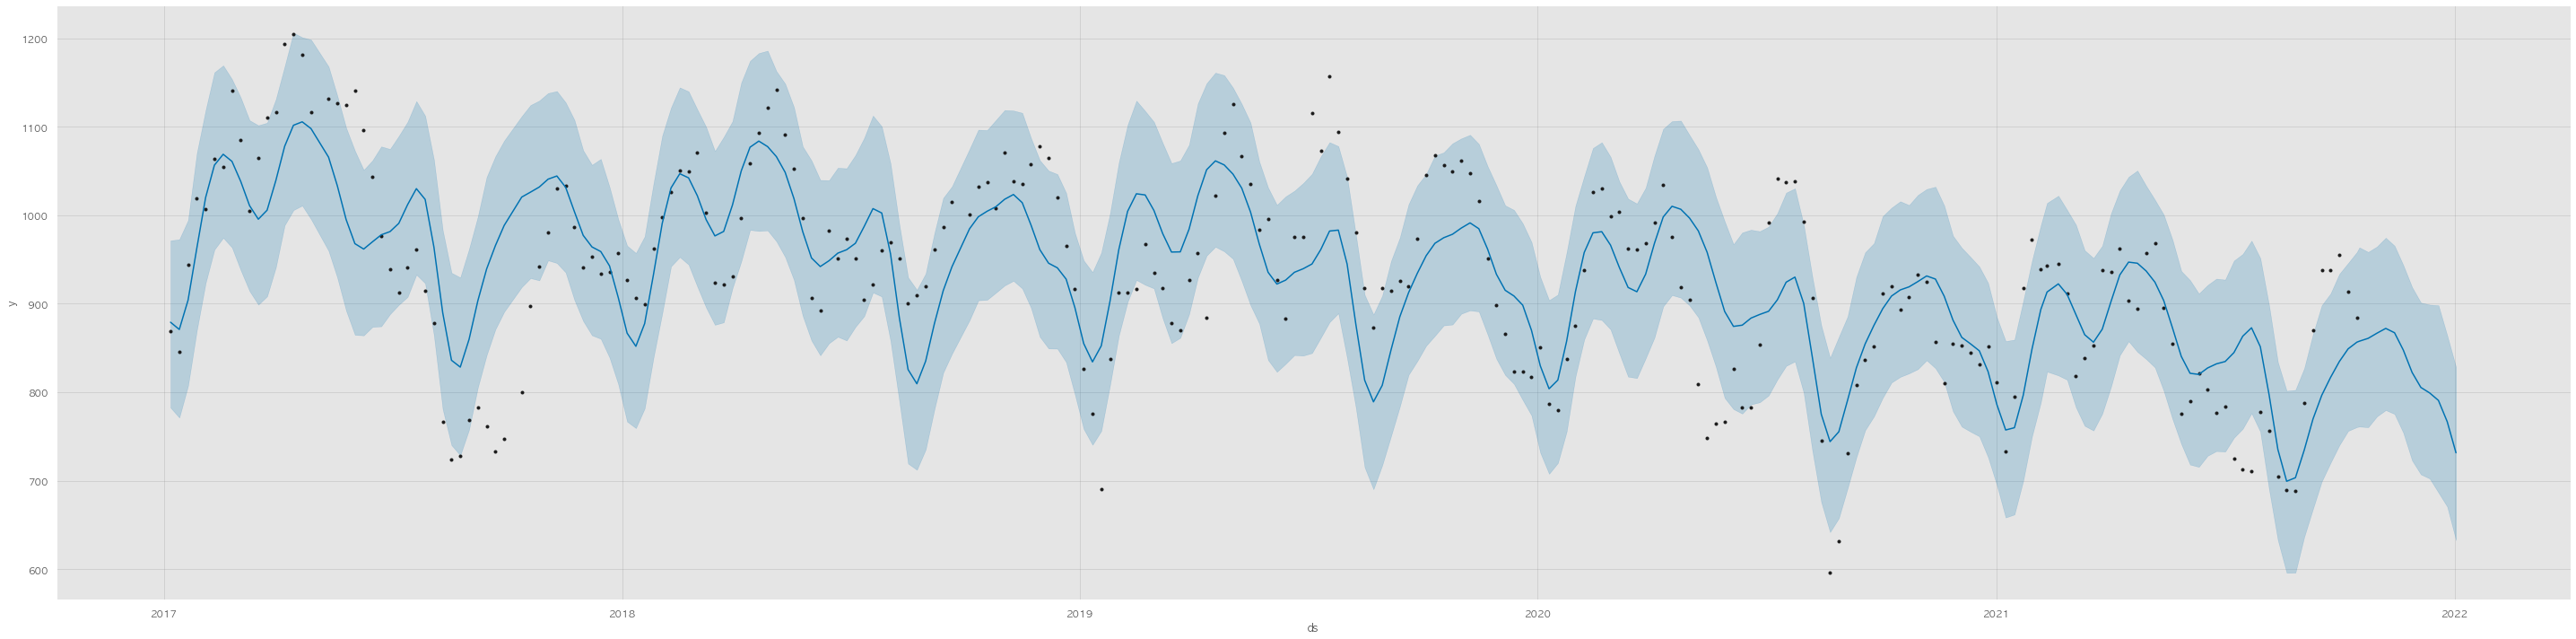

In [76]:
# prophet 모델을 학습
# df['stock'] 국내 철강사 제고량이 시계열 특성을 가지고 있으므로 prophet으로 시황성 자제 제고를 예측
df_for_p = pd.DataFrame()
df_for_p['ds'] = df['date']
df_for_p['y'] = df['stock']
df_for_p.head()
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_prior_scale=0.05)
prophet.fit(df_for_p)
#12주 예측
future_data = prophet.make_future_dataframe(periods=12, freq='w')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data, figsize = (40,10)) 

fig.savefig('./result_img01/prophet_stock_12_w.png', dpi = 100)

In [77]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-06,1000.161491,782.661296,971.531878,1000.161491,1000.161491,-0.120998,-0.120998,-0.120998,-0.120998,-0.120998,-0.120998,0.0,0.0,0.0,879.143780
1,2017-01-13,999.778174,771.375164,972.778938,999.778174,999.778174,-0.128852,-0.128852,-0.128852,-0.128852,-0.128852,-0.128852,0.0,0.0,0.0,870.954613
2,2017-01-20,999.394856,807.495103,994.448649,999.394856,999.394856,-0.095314,-0.095314,-0.095314,-0.095314,-0.095314,-0.095314,0.0,0.0,0.0,904.138157
3,2017-01-27,999.011538,870.118720,1070.312757,999.011538,999.011538,-0.036007,-0.036007,-0.036007,-0.036007,-0.036007,-0.036007,0.0,0.0,0.0,963.040122
4,2017-02-03,998.628221,923.549437,1118.781936,998.628221,998.628221,0.021529,0.021529,0.021529,0.021529,0.021529,0.021529,0.0,0.0,0.0,1020.127741


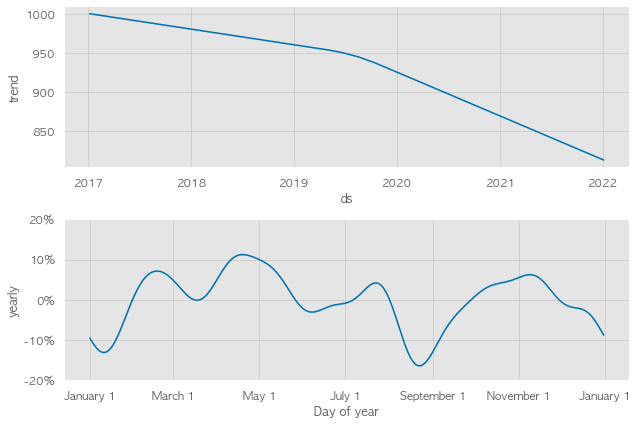

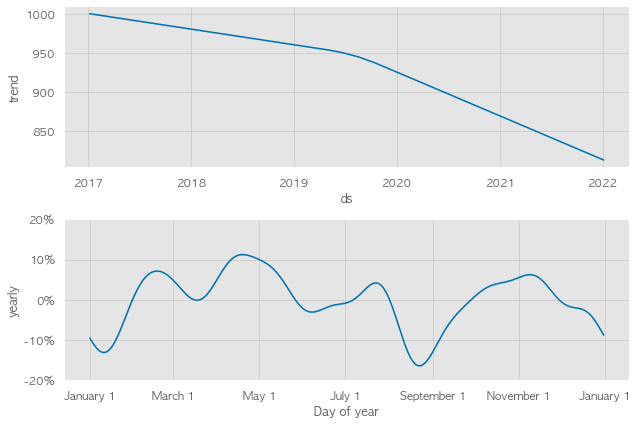

In [78]:
prophet.plot_components(forecast_data)


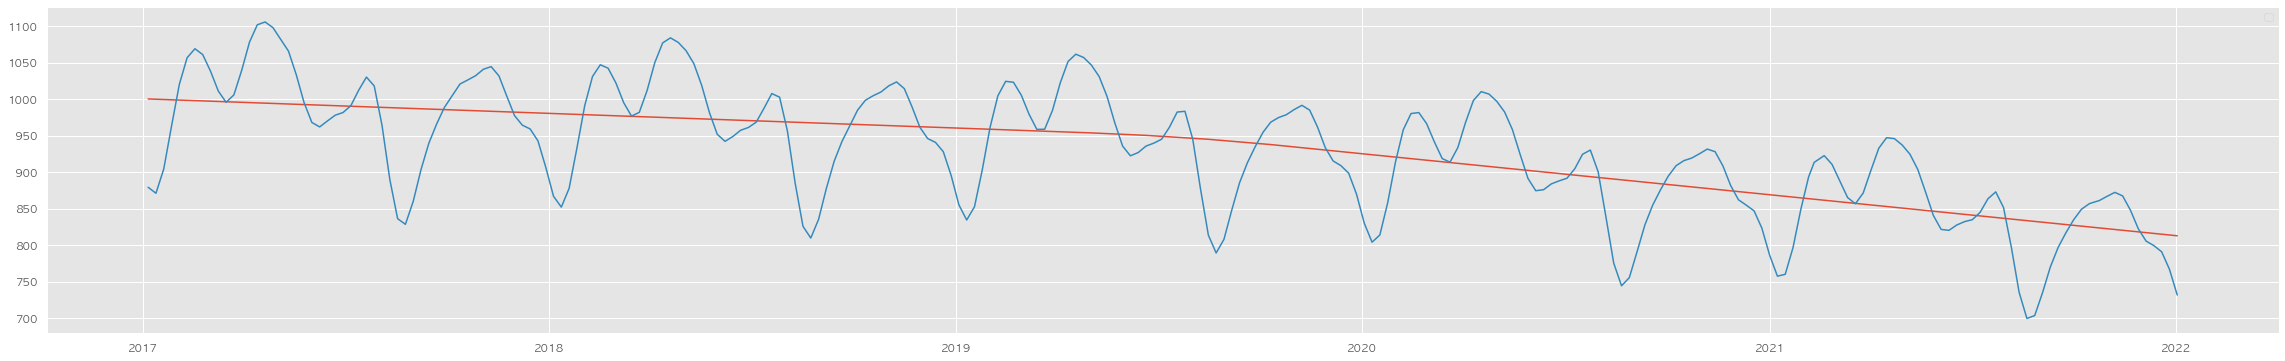

In [79]:

plt.plot(forecast_data['ds'], forecast_data['trend'])
 
plt.plot(forecast_data['ds'], forecast_data['yhat'])

plt.legend()
plt.show()

In [80]:
forecast_data['trend'].head()

0    1000.161491
1     999.778174
2     999.394856
3     999.011538
4     998.628221
Name: trend, dtype: float64

In [81]:
forecast_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
254,2021-12-05,817.007487,707.218820,901.274214,816.921593,817.119941,-0.014149,-0.014149,-0.014149,-0.014149,-0.014149,-0.014149,0.0,0.0,0.0,805.448053
255,2021-12-12,815.932175,702.547845,899.012133,815.819650,816.077179,-0.020471,-0.020471,-0.020471,-0.020471,-0.020471,-0.020471,0.0,0.0,0.0,799.229451
256,2021-12-19,814.856862,686.699668,898.230522,814.708467,815.034031,-0.029539,-0.029539,-0.029539,-0.029539,-0.029539,-0.029539,0.0,0.0,0.0,790.786427
257,2021-12-26,813.781550,670.829398,864.203688,813.603138,814.000363,-0.057740,-0.057740,-0.057740,-0.057740,-0.057740,-0.057740,0.0,0.0,0.0,766.793552
258,2022-01-02,812.706237,632.859914,828.460448,812.491429,812.975382,-0.099813,-0.099813,-0.099813,-0.099813,-0.099813,-0.099813,0.0,0.0,0.0,731.587661


In [82]:

#pd.merge(df, forecast_data.trend, how='outer', on='')
df['stock_trend'] = forecast_data['trend']
df = df.drop(columns=['quarter'])


In [83]:
df.to_csv("data/step1.csv", index=False)
df1 = df.copy()

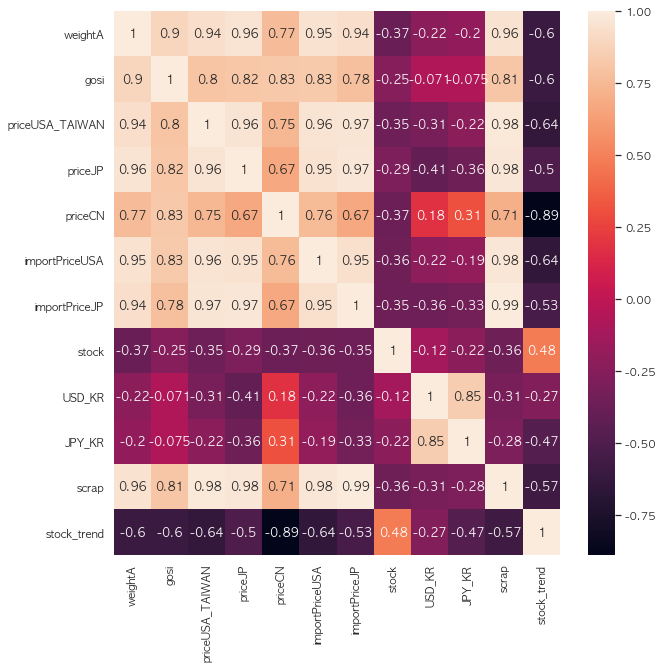

In [84]:
# 상관관계 분석  
import seaborn as sns
# 상관관계 행렬 
df_corr = df.corr()
#Drawing HEAT MAP
fig = plt.figure (figsize=(10,10))
sns.set(font_scale=1, font="AppleGothic")
sns.heatmap(df_corr, annot=True, cbar=True);
plt.show()


fig.savefig('./result_img01/corr_heatmap2.png', dpi = 100)

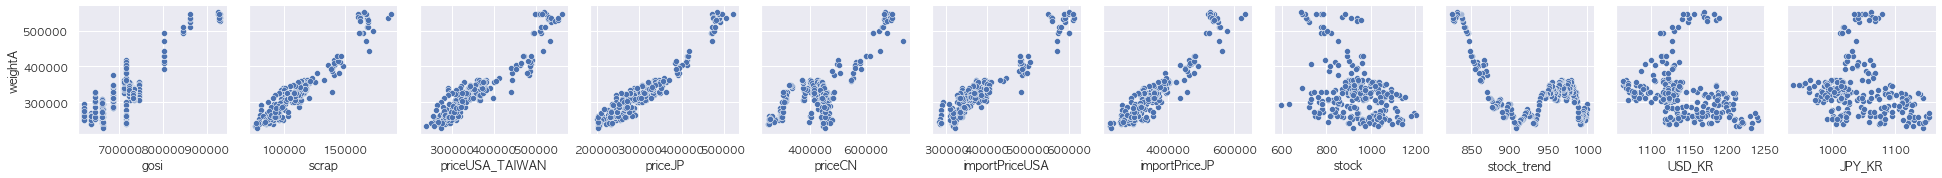

In [85]:
#산점도 행렬, 변수간의 경향성 파익- 그래프 분석
sns.pairplot (df, y_vars="weightA", x_vars=["gosi","scrap", "priceUSA_TAIWAN", "priceJP", "priceCN", "importPriceUSA", "importPriceJP","stock", "stock_trend", "USD_KR", "JPY_KR"], diag_kind=None)

## 목표변수(weightA와 설명변수들간의 선형관계 확인)

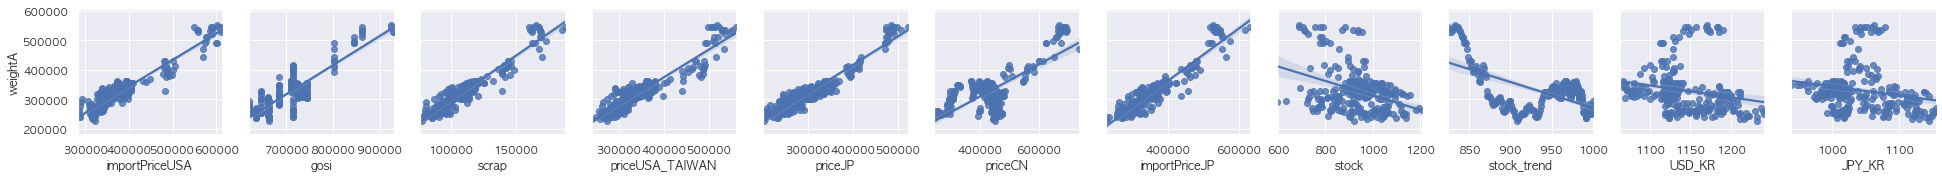

In [86]:
#y=weightA / 회귀 적합선 추가
sns.pairplot(df, y_vars="weightA", x_vars=["importPriceUSA","gosi","scrap", "priceUSA_TAIWAN", "priceJP", "priceCN",  "importPriceJP", "stock", "stock_trend", "USD_KR", "JPY_KR"], kind="reg", diag_kind="reg")

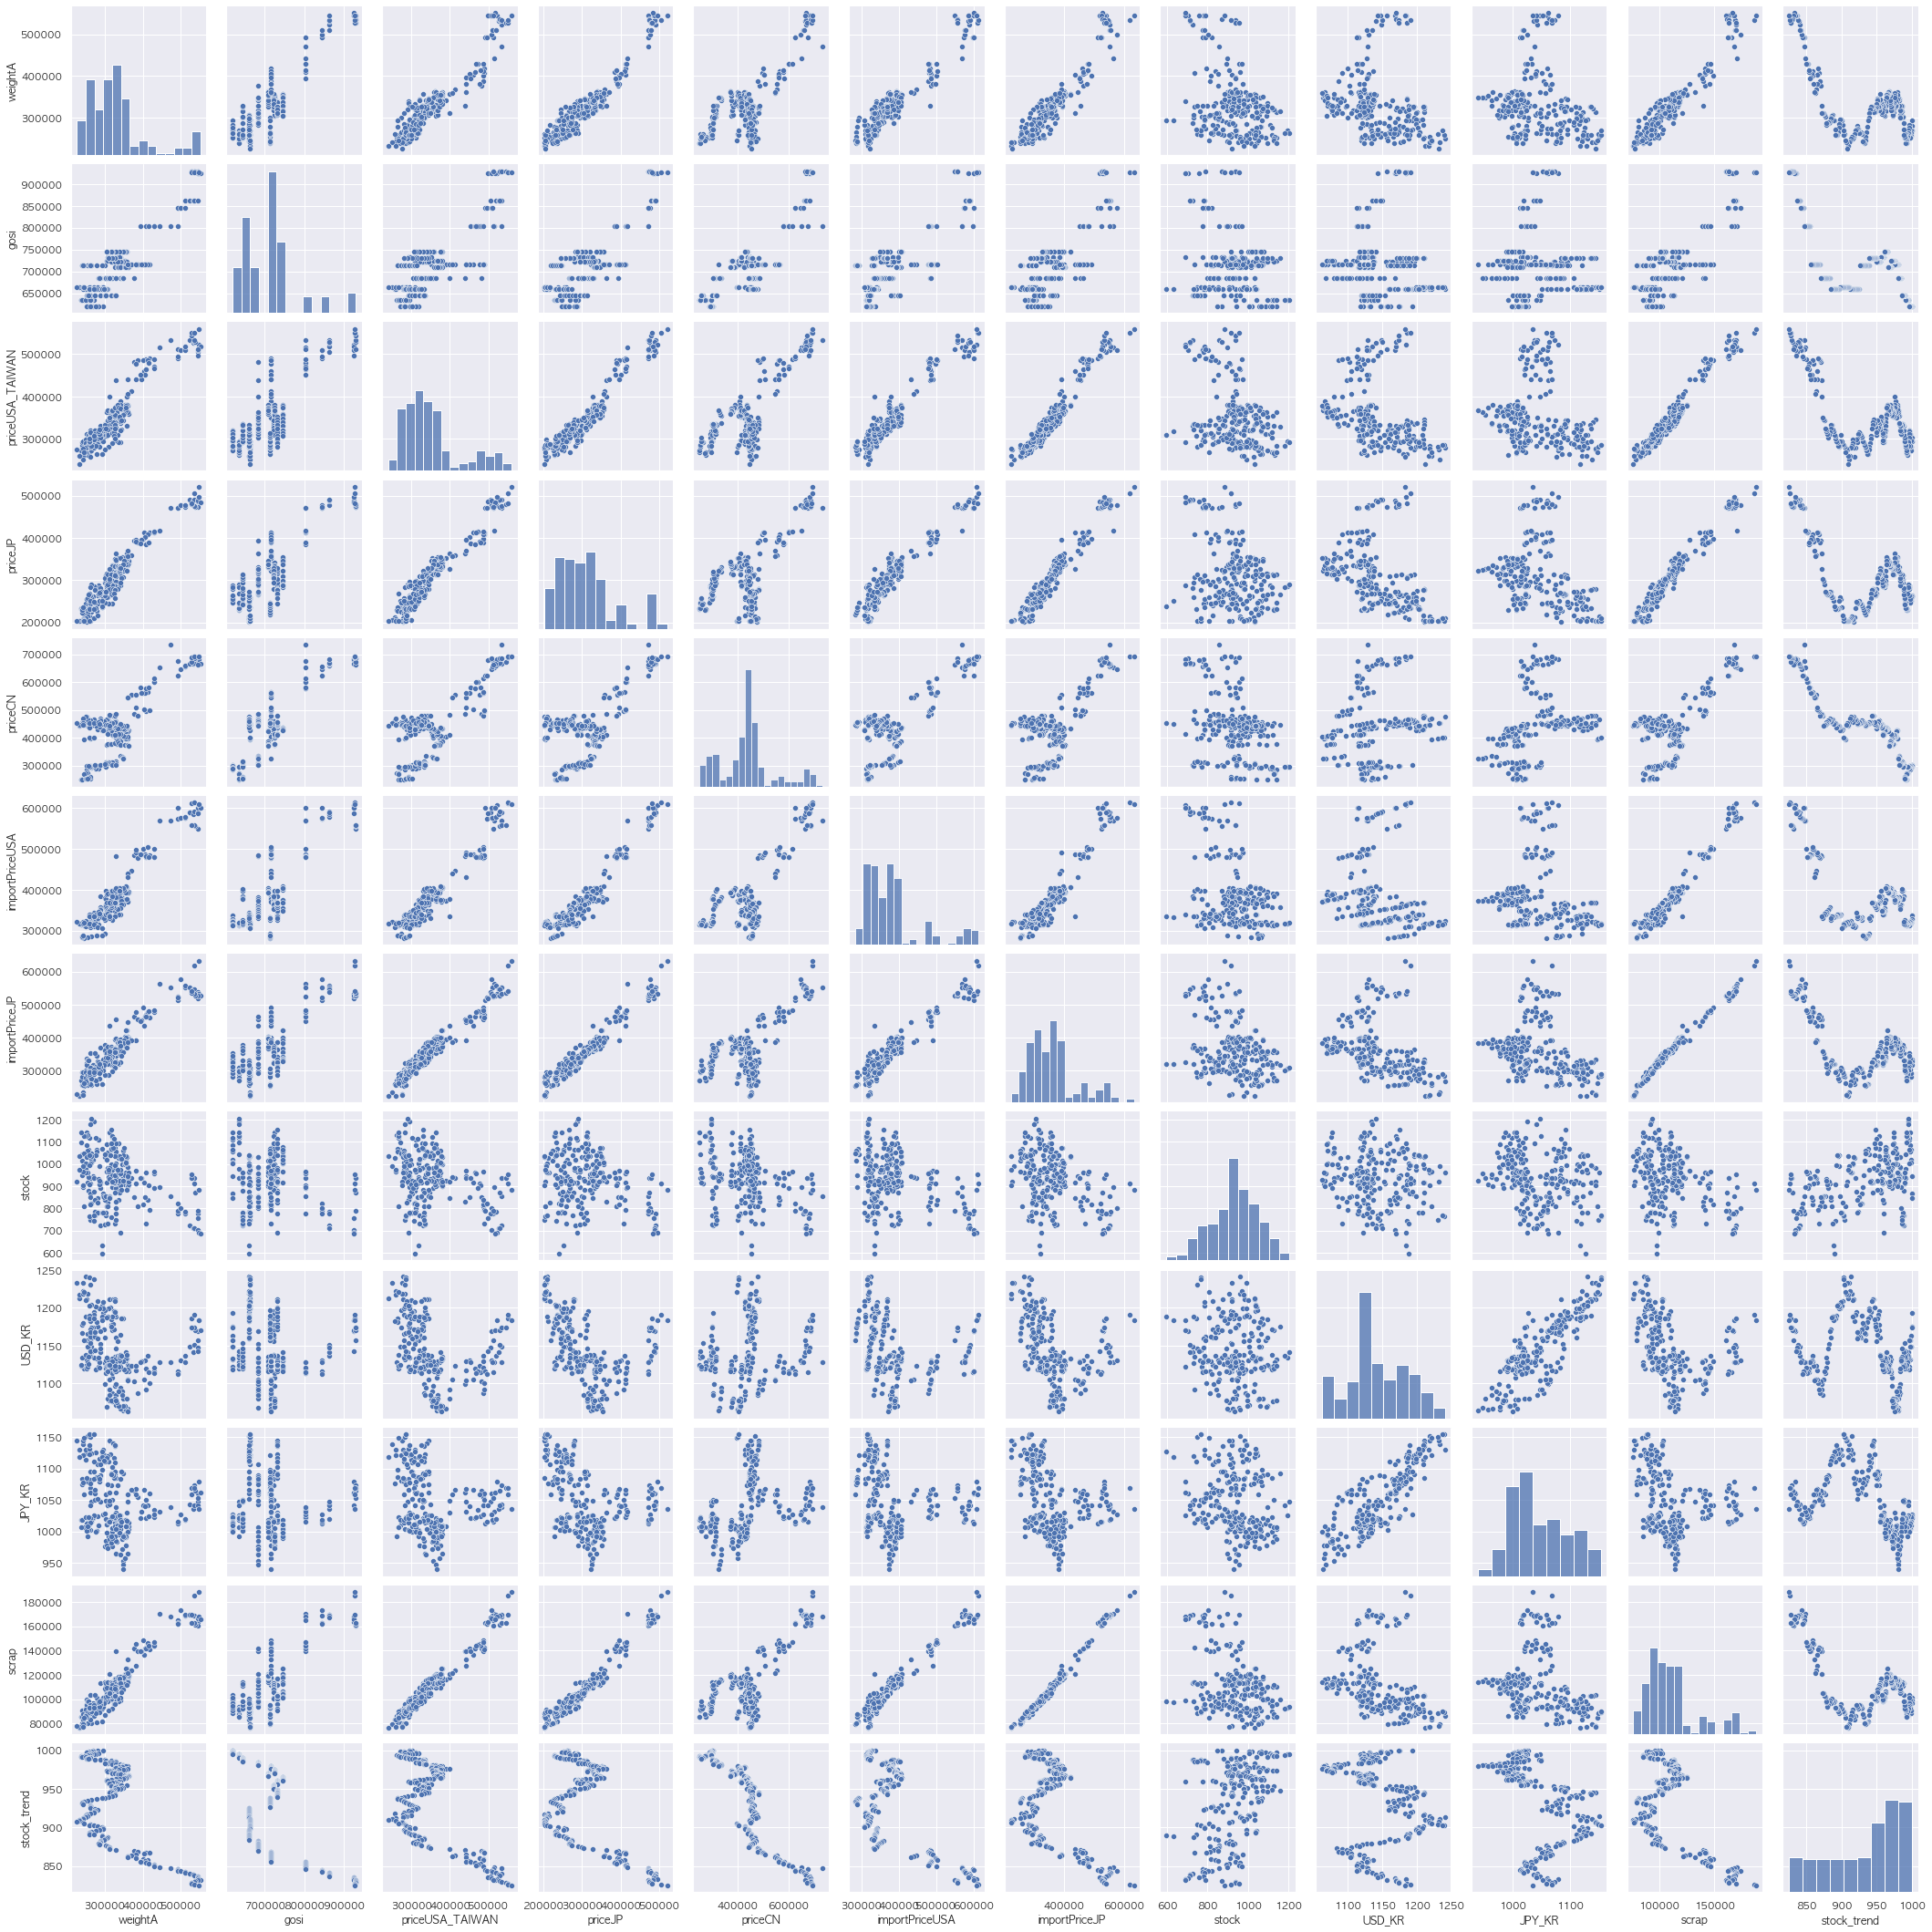

In [87]:
#weight기준
sns.pairplot(df)

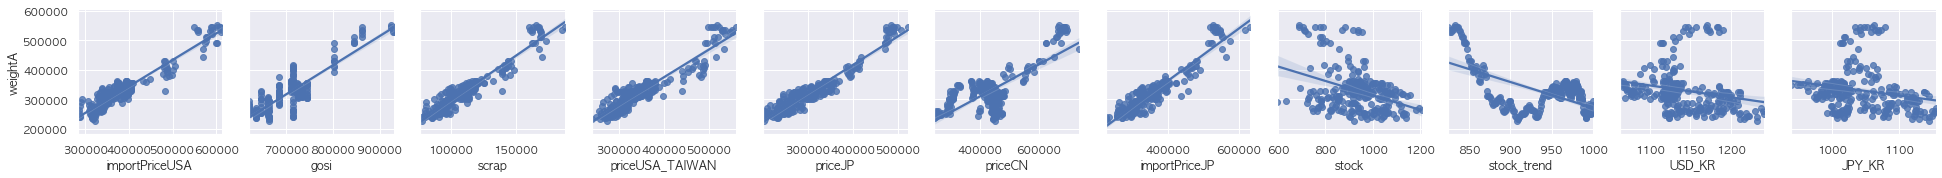

In [88]:
#y=weightA / 회귀 적합선 추가
sns.pairplot(df, y_vars="weightA", x_vars=["importPriceUSA","gosi","scrap", "priceUSA_TAIWAN", "priceJP", "priceCN",  "importPriceJP", "stock", "stock_trend", "USD_KR", "JPY_KR"], kind="reg", diag_kind="reg")

### 추가: 목표변수가 각각 importPriceUSA와 importPriceJP 일 때

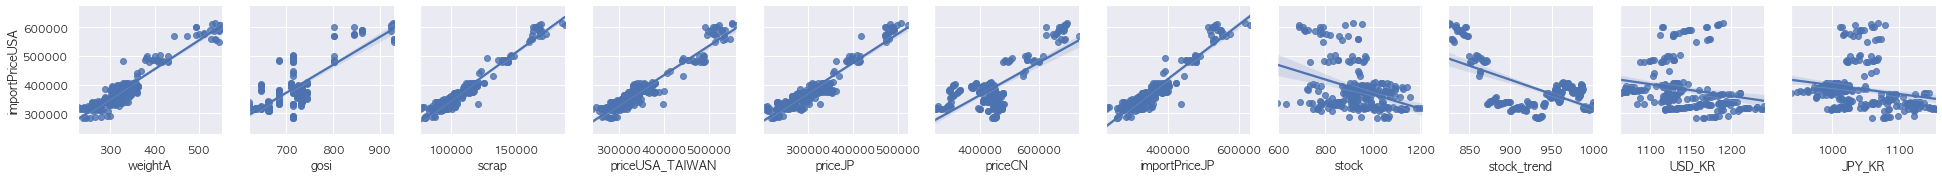

In [177]:
#y=mportPriceUSA / 회귀 적합선 추가
sns.pairplot(df, y_vars="importPriceUSA", x_vars=["weightA", "gosi","scrap", "priceUSA_TAIWAN", "priceJP", "priceCN", "importPriceJP", "stock", "stock_trend", "USD_KR", "JPY_KR"], kind="reg", diag_kind="reg")

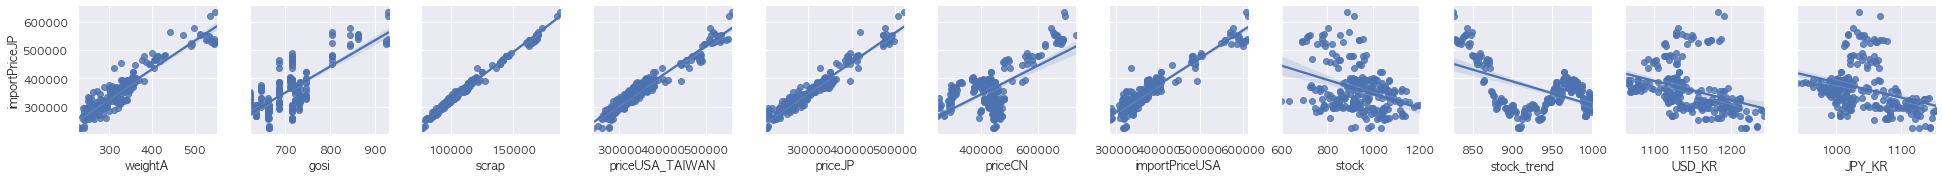

In [178]:
#y=importPriceJP / 회귀 적합선 추가
sns.pairplot(df, y_vars="importPriceJP", x_vars=["weightA", "gosi","scrap", "priceUSA_TAIWAN", "priceJP", "priceCN", "importPriceUSA",  "stock", "stock_trend", "USD_KR", "JPY_KR"], kind="reg", diag_kind="reg")

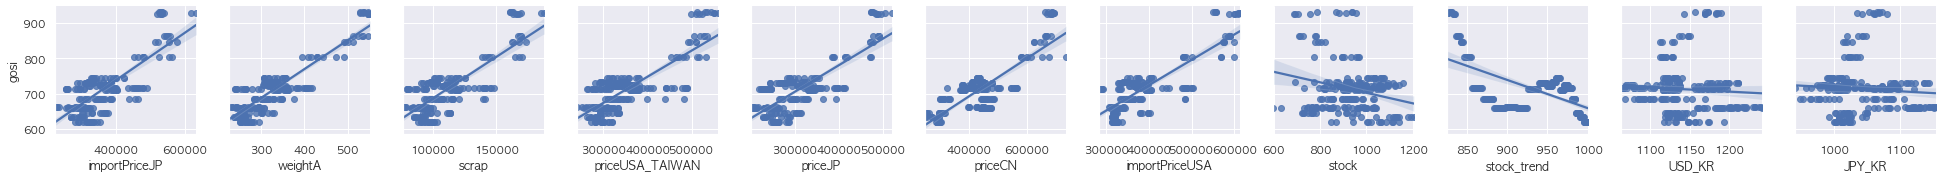

In [186]:
#y=importPriceJP / 회귀 적합선 추가
sns.pairplot(df, y_vars="gosi", x_vars=["importPriceJP", "weightA", "scrap", "priceUSA_TAIWAN", "priceJP", "priceCN", "importPriceUSA",  "stock", "stock_trend", "USD_KR", "JPY_KR"], kind="reg", diag_kind="reg")

In [89]:
df.corr().round(3)
#weightA를 제외한 다른 줄들에서, 한줄에 0.7이상인 값들이  많고, 다중공선성 확인 필요함

,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend
weightA,1.000,0.896,0.937,0.959,0.768,0.952,0.940,-0.371,-0.221,-0.200,0.955,-0.599
gosi,0.896,1.000,0.804,0.816,0.827,0.832,0.785,-0.246,-0.071,-0.075,0.810,-0.598
priceUSA_TAIWAN,0.937,0.804,1.000,0.961,0.748,0.960,0.970,-0.352,-0.312,-0.220,0.978,-0.636
priceJP,0.959,0.816,0.961,1.000,0.668,0.952,0.973,-0.290,-0.406,-0.359,0.978,-0.500
priceCN,0.768,0.827,0.748,0.668,1.000,0.762,0.669,-0.370,0.185,0.308,0.708,-0.887
importPriceUSA,0.952,0.832,0.960,0.952,0.762,1.000,0.948,-0.363,-0.215,-0.190,0.977,-0.638
importPriceJP,0.940,0.785,0.970,0.973,0.669,0.948,1.000,-0.352,-0.355,-0.327,0.994,-0.530
stock,-0.371,-0.246,-0.352,-0.290,-0.370,-0.363,-0.352,1.000,-0.121,-0.224,-0.360,0.480
USD_KR,-0.221,-0.071,-0.312,-0.406,0.185,-0.215,-0.355,-0.121,1.000,0.847,-0.312,-0.266
JPY_KR,-0.200,-0.075,-0.220,-0.359,0.308,-0.190,-0.327,-0.224,0.847,1.000,-0.285,-0.468


In [101]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1242)
print ("Train data size {}".format(df_train.shape))
print ("Test data size {}".format(df_test.shape))

Train data size (172, 13)
Test data size (75, 13)


In [102]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ importPriceUSA +scrap + gosi +   priceCN + stock_trend+  stock +priceJP +  USD_KR + JPY_KR+ priceUSA_TAIWAN + importPriceJP", data=df )  # 
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.043e+26
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:41:37   Log-Likelihood:                 3897.4
No. Observations:                 247   AIC:                            -7771.
Df Residuals:                     235   BIC:                            -7729.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.499e-07   1.91e-07     

In [105]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ importPriceUSA +scrap  +   priceCN +   USD_KR + JPY_KR+ priceUSA_TAIWAN + importPriceJP", data=df )  # stock_trend+  +priceJP stock+ + gosi
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.502e+25
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:42:51   Log-Likelihood:                 3828.0
No. Observations:                 247   AIC:                            -7640.
Df Residuals:                     239   BIC:                            -7612.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.288e-07   1.21e-07     

In [94]:
#선형회귀분석
#reg_model = smf.ols(formula="gosi ~ weightA+ priceJP + importPriceJP+ priceCN+ stock_trend + JPY_KR", data=df ) # priceUSA_TAIWAN 제거 importPriceUSA 제거 scrap + stock +
#reg_result = reg_model.fit()
#print(reg_result.summary())

In [108]:
#다중공선성 확인
#전체항목
df_raw_x = df_train[[  'importPriceUSA','priceUSA_TAIWAN','priceJP','priceCN','importPriceJP','USD_KR','stock' ,'JPY_KR', 'scrap' ,'gosi','stock_trend']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



,variable,VIF
7,stock,1.864
6,USD_KR,6.249
8,JPY_KR,7.894
11,stock_trend,10.452
10,gosi,11.386
4,priceCN,17.238
2,priceUSA_TAIWAN,43.369
3,priceJP,68.917
0,const,7209.266
1,importPriceUSA,1022835.711


In [117]:
#다중공선성 확인
#전체항목
df_raw_x = df_train[[  'priceJP','USD_KR','stock' ,'JPY_KR','gosi']]#'stock_trend'
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



,variable,VIF
3,stock,1.318
4,JPY_KR,3.262
2,USD_KR,3.446
5,gosi,4.205
1,priceJP,5.340
0,const,1443.120


                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.043e+26
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:41:15   Log-Likelihood:                 3897.4
No. Observations:                 247   AIC:                            -7771.
Df Residuals:                     235   BIC:                            -7729.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.499e-07   1.91e-07     

In [116]:
#선형회귀분석 
reg_model = smf.ols(formula="weightA ~ importPriceUSA +scrap  +   priceCN +   USD_KR + JPY_KR+ priceUSA_TAIWAN + importPriceJP", data=df )  # stock_trend+  +priceJP stock+ + gosi
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.502e+25
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:47:22   Log-Likelihood:                 3828.0
No. Observations:                 247   AIC:                            -7640.
Df Residuals:                     239   BIC:                            -7612.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.288e-07   1.21e-07     

In [107]:
#다중공선성 확인
#전체항목
df_raw_x = df_train[['importPriceUSA','priceUSA_TAIWAN','priceJP','priceCN','importPriceJP','USD_KR','stock' ,'JPY_KR','gosi','scrap' , 'stock_trend']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



,variable,VIF
7,stock,1.864
6,USD_KR,6.249
8,JPY_KR,7.894
11,stock_trend,10.452
9,gosi,11.386
4,priceCN,17.238
2,priceUSA_TAIWAN,43.369
3,priceJP,68.917
0,const,7209.266
1,importPriceUSA,1022835.711


In [50]:
#다중공선성 확인
#다중공선성은 10 이상이면 제거대상임
## 해당 항목 5개로 결정
df_raw_x = df_train[[ 'stock' ,'gosi', 'priceJP', 'priceCN', 'USD_KR', 'JPY_KR']]#'gosi'  'stock_trend'  'priceUSA_TAIWAN' 'JPY_KR','importPriceUSA' 'USD_KR' 'importPriceUSA'  'priceUSA_TAIWAN'

df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const,i) for i in range(df_raw_x_const.shape[1])]
#sorting VIF
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)



,variable,VIF
1,stock,1.321
5,USD_KR,3.540
6,JPY_KR,5.706
2,gosi,6.555
3,priceJP,6.746
4,priceCN,8.531
0,const,2640.731


In [152]:
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()


#모델에 기여하는 변수를 확인
y =  df1["weightA"]
#다중공선성 높은 값들 제거
'''
1	stock	1.321
5	USD_KR	3.540
6	JPY_KR	5.706
2	gosi	6.555
3	priceJP	6.746
4	priceCN	8.531
0	const	2138.864
'''

#X = df[[ "stock","priceJP", "USD_KR" ,"gosi", "priceCN"]]
X = df[[ "USD_KR" , "priceJP", "gosi", "priceCN",  "JPY_KR" ,"stock"]]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
#coef['coeffiecient_abs'] =coef['coefficient'].abs()
res_coef1 = coef.sort_values(by ='coefficient', ascending=False)

res_coef1.to_csv("data/step1_coef_gosi.csv",index=False)
res_coef1


0.9707040343424792
0.9796821969085288


,feature_names,coefficient
0,USD_KR,190.897048
1,priceJP,0.764029
2,gosi,0.311377
3,priceCN,-0.012755
4,JPY_KR,-26.523224
5,stock,-50.341654


In [146]:
#선형회귀분석
#"USD_KR" , "priceJP", "gosi", "priceCN",  "JPY_KR" ,"stock"a
reg_model = smf.ols(formula="weightA ~ priceCN + priceJP+  USD_KR + JPY_KR+  stock + gosi", data=df )  # stock_trend+  +priceJP stock+ + gosi
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1446.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          2.73e-185
Time:                        01:17:37   Log-Likelihood:                -2676.8
No. Observations:                 247   AIC:                             5368.
Df Residuals:                     240   BIC:                             5392.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.737e+05   4.08e+04     -6.715      0.0

In [153]:
model.intercept_

-265718.6935815305

In [151]:


### STATSMODELS ###

# you have to create a DataFrame since the Statsmodels formula interface expects it
#X_new = pd.DataFrame()

# predict for a new observation
reg_model.predict(50)


array([[5.0000000e+01, 1.5121645e+07, 1.3046585e+07, ..., 5.1364500e+04,
        4.3450000e+04, 3.1000000e+07],
       [5.0000000e+01, 1.4887250e+07, 1.3155700e+07, ..., 5.1189500e+04,
        4.2300000e+04, 3.1000000e+07],
       [5.0000000e+01, 1.4874580e+07, 1.3069570e+07, ..., 5.1053000e+04,
        4.7200000e+04, 3.1000000e+07],
       ...,
       [5.0000000e+01, 3.4512600e+07, 2.4083150e+07, ..., 5.2930000e+04,
        4.7750000e+04, 4.6400000e+07],
       [5.0000000e+01, 3.4703075e+07, 2.5271915e+07, ..., 5.3429000e+04,
        4.5700000e+04, 4.6400000e+07],
       [5.0000000e+01, 3.4602750e+07, 2.6031255e+07, ..., 5.1752000e+04,
        4.4200000e+04, 4.6400000e+07]])

In [133]:

# 시계열 모델에서 예측된 각각의 값들
dfe = pd.read_csv("./data/steeldata_rate_applied20211023.csv")
#날짜형으로 변환
dfe['date'] = pd.to_datetime(dfe['date'], format='%Y-%m-%d')
dfe.head()
df_weight = pd.read_csv("./data/weightA_1022_2021-10-22T12-54-16Z_part0.csv")
df_weight['date'] = pd.to_datetime(df_weight['date'], format='%Y-%m-%d')
frames = [dfe, df_weight]
dfa = pd.concat(frames)


In [174]:
len_matrics = len(dfe[dfe.metric_name=='importPriceUSA']) -1
 
arr = []
for i in range(len_matrics):
    a =  [
        dfe[dfe.metric_name=='USD_KR'].p10.iloc[i], 
        dfa[dfa.metric_name=='priceJP'].p10.iloc[i], 
        dfa[dfa.metric_name=='gosi'].p10.iloc[i], 
        dfa[dfa.metric_name=='priceCN'].p10.iloc[i],
        dfa[dfa.metric_name=='JPY_KR'].p10.iloc[i],
        dfa[dfa.metric_name=='stock'].p10.iloc[i]]
    arr.append(a)
arr

[[1151.203, 500351.8, 903.0576, 686341.3, 1032.833, 777.78],
 [1175.62, 324260.5, 907.1224, 443736.9, 775.6727, 769.48],
 [1179.486, 484060.8, 912.5538, 666606.4, 1022.334, 753.35],
 [1180.964, 489970.9, 905.916, 675731.7, 1020.358, 831.57],
 [1206.948, 492305.4, 912.5978, 674308.1, 1016.959, 740.2],
 [1235.205, 522218.0, 929.4136, 718807.2, 1012.959, 728.54],
 [1246.803, 493024.3, 907.7676, 677451.8, 868.8513, 748.55],
 [1249.87, 457190.7, 908.2992, 631084.1, 613.6587, 682.16],
 [1259.37, 510160.9, 916.7929, 702956.9, 1011.329, 716.38],
 [1263.839, 512718.3, 918.7462, 706297.1, 1015.256, 738.4],
 [1261.01, 561898.9, 949.1796, 778126.5, 1033.372, 781.9],
 [1265.016, 523004.4, 939.2537, 720104.8, 1010.198, 734.35],
 [1272.833, 534106.9, 942.2772, 734923.6, 1006.615, 722.98],
 [1273.537, 607860.4, 961.4474, 837715.3, 1037.235, 795.29],
 [1272.47, 433759.8, 846.0275, 601969.3, 744.5845, 684.42],
 [1273.048, 528276.1, 940.223, 731823.0, 1003.382, 722.88],
 [1266.096, 529641.1, 948.2989, 73

In [175]:
#print('Parameters: ', reg_result.params)
#print('R2: ', reg_result.rsquared)

In [176]:
res_arr = model.predict(arr)
res_arr

array([261303.87886503, 141760.42248549, 256019.21477026, 256813.07267055,
       268267.07664849, 296646.06871444, 279890.87696701, 263800.75193266,
       292900.7516751 , 294453.12202881, 327911.40468517, 302704.99149994,
       313159.20900072, 363885.91548232, 246978.76357629, 308875.04287245,
       308682.44296491, 354058.9827506 , 322339.29526971])

In [177]:
for i in res_arr:
    print( (i+model.intercept_*-1 ) * 0.001)

527.0225724465564
407.47911606702536
521.7379083517927
522.5317662520822
533.9857702300217
562.3647622959722
545.6095705485443
529.5194455141913
558.6194452566308
560.1718156103406
593.6300982666993
568.4236850814697
578.8779025822489
629.6046090638537
512.6974571578199
574.5937364539767
574.4011365464445
619.7776763321334
588.0579888512406


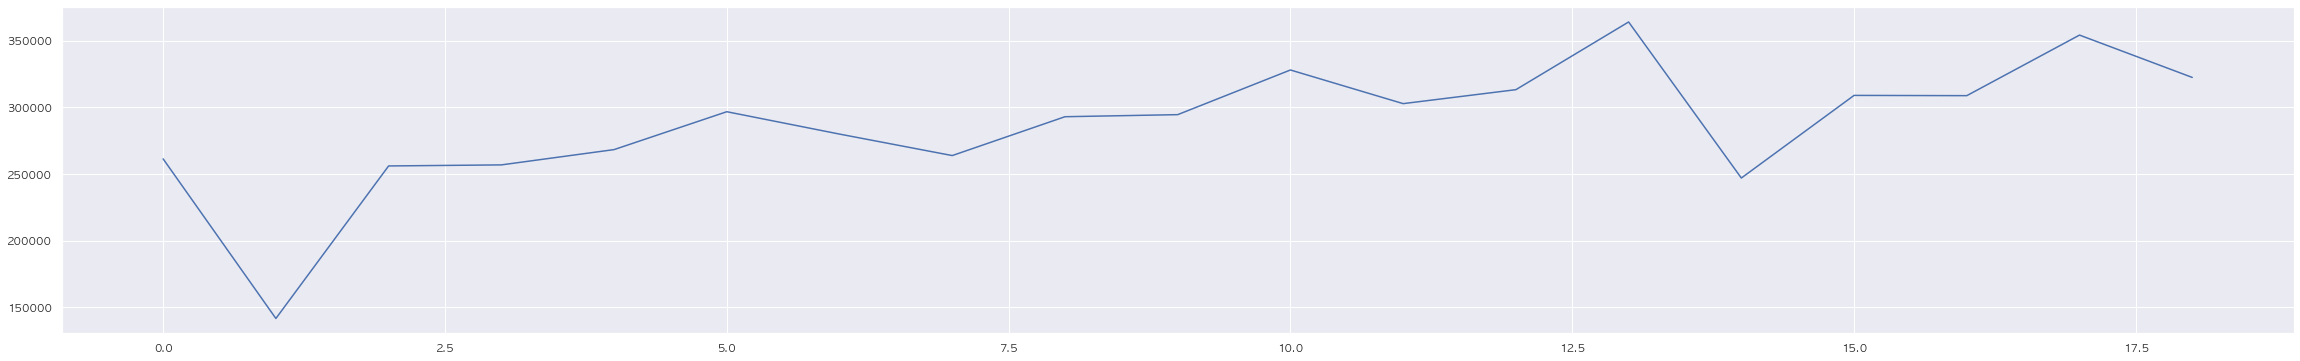

In [178]:
plt.plot(res_arr)
plt.show()

In [216]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ stock + gosi + priceJP +   USD_KR", data=df )  # priceCN
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                weightA   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2174.
Date:                Sat, 23 Oct 2021   Prob (F-statistic):          2.57e-188
Time:                        20:24:39   Log-Likelihood:                -971.30
No. Observations:                 247   AIC:                             1953.
Df Residuals:                     242   BIC:                             1970.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -271.3456     30.276     -8.962      0.0

In [ ]:
#선형회귀분석
reg_model = smf.ols(formula="weightA ~ stock + gosi + priceJP +   USD_KR", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

In [ ]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet
df_raw_y = df["weightA"]
df_raw_x = X#df.drop(["date", "weightA"], axis = 1 , inplace=False)
X_train, X_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size = 0.2)
ridge = Ridge(alpha=1, random_state = 1234)
ridge.fit(X_train, y_train)
print(round(ridge.score(X_train, y_train), 3))
print(round(ridge.score(X_test, y_test), 3))

In [ ]:
df_ridge = pd.DataFrame()
df_ridge["variable"] = X_train.columns
df_ridge["Coef"] = pd.DataFrame(ridge.coef_)
df_ridge

'\n1\tstock\t1.262\n5\tUSD_KR\t2.277\n4\tpriceCN\t4.430\n2\tgosi\t5.768\n3\tpriceJP\t6.154\n0\tconst\t2138.864\n'

LinearRegression()

0.9768291483381499
0.9519882623570769


,feature_names,coefficient
3,gosi,0.281152
2,USD_KR,0.160431
1,priceJP,0.000778
4,priceCN,-0.000002
0,stock,-0.048432


In [ ]:
#보관용
reg_model = smf.ols(formula="weightA ~  importPriceUSA+ USD_KR+  stock+ priceCN ", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

In [ ]:
#보관용
reg_model = smf.ols(formula="weightA ~  importPriceUSA+ USD_KR+  stock+ priceCN ", data=df ) 
reg_result = reg_model.fit()
print(reg_result.summary())

In [ ]:

# 상관관계 분석  
import seaborn as sns
# 상관관계 행렬 
df_corr = df.corr()
#Drawing HEAT MAP
fig = plt.figure (figsize=(10,10))
sns.set(font_scale=1, font="AppleGothic")
sns.heatmap(df_corr, annot=True, cbar=True);
plt.show()


fig.savefig('./result_img01/corr_heatmap2.png', dpi = 100)

In [ ]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")
#잔차가 y=0을 기준으로 Random하게 산포되어 있으므로 등분산성 만족함

In [ ]:
import numpy as np
plt.scatter(df.index, reg_result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="-")
plt.axhline( y = 3 * np.std(reg_result.resid), linestyle="--")
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="--")


In [ ]:
qqplot(reg_result.resid,line="q")